# MSSE 277B: Machine Learning Algorithms 

## Homework assignment #4: Regression 

### Student Name: Charis Liao 

#### Assigned Feb.16 and Due Feb.28 


In [116]:
# import all the packages needed 
import pandas as pd 
import numpy as np
import math 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


#### 1. Linear Regression using a simple perceptron 

For getting into graduate school, download the grad school attribute data set from Files. 
 

In [32]:
admission = pd.read_csv("Admission_Predict_Ver1.1.csv")
admission.head(5)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


(a) Define the features that are related to predicting the Chance of Admit, and normalize them.     
 

In [37]:
# Define the features that are related to predicting the chance of admission 
features = admission[["GRE Score", "TOEFL Score", "University Rating", "SOP", "LOR ", "CGPA", "Research"]]
features = (features - features.mean()) / features.std()
numpy_features = features.values
print(numpy_features.shape)
features.head(5)


(500, 7)


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,1.817417,1.777086,0.774806,1.136222,1.097845,1.775029,0.885518
1,0.666481,-0.031569,0.774806,0.631683,1.097845,0.485373,0.885518
2,-0.041788,-0.524839,-0.099693,-0.377395,0.017289,-0.953088,0.885518
3,0.489414,0.461700,-0.099693,0.127144,-1.063267,0.154692,0.885518
4,-0.218855,-0.689262,-0.974192,-1.386473,-0.522989,-0.605873,-1.127023



(b) Fill in the code for a simple perceptron. Initialize your weights and biases between 0 and 0.05 using your random number generator. Use the mean square error (MSE) to adjust your weights through back-propagation. Fill in the blanks for the feedforward and backpropagation step.       



In [63]:
class simple_perceptron():
    def __init__(self,input_dim,output_dim,learning_rate=0.01,activation=lambda x:x,activation_grad=lambda x:1):
        
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.activation=activation
        self.activation_grad=activation_grad
        self.lr=learning_rate
        ### initialize parameters ###
        self.weights=np.random.rand(input_dim,output_dim)*0.05
        self.biases=np.random.rand(1, output_dim)*0.05

    def predict(self,X):
        if len(X.shape)==1:
            X=X.reshape((-1,1))
        dim=X.shape[1]
        # Check that the dimension of accepted input data is the same as expected
        if not dim==self.input_dim:
            raise Exception("Expected input size %d, accepted %d!"%(self.input_dim,dim))
        ### Calculate logit and activation ###
        self.z = X.dot(self.weights)+self.biases             #shape(X.shape[0],1)
        self.a = self.activation(self.z)           #shape(X.shape[0],1)
        return self.a
    
    def fit(self,X,y):
        # Transform the single-sample data into 2-dimensional, for the convenience of matrix multiplication
        if len(X.shape)==1:
            X=X.reshape((-1,1))
        if len(y.shape)==1:
            y=y.reshape((-1,1))
        self.predict(X)
        errors=(self.a-y)*self.activation_grad(self.z)
        weights_grad=errors.T.dot(X)
        bias_grad=np.sum(errors,axis=0)
        ### Update weights and biases from the gradient ###
        self.weights -=self.lr*weights_grad.T
        self.biases -=self.lr*bias_grad

        
    def train_on_epoch(self,X,y,batch_size=32):
        # Every time select batch_size samples from the training set, until all data in the training set has been trained once
        order=list(range(X.shape[0]))
        np.random.shuffle(order)
        n=0
        while n<math.ceil(len(order)/batch_size)-1: # Parts that can fill one batch
            self.fit(X[order[n*batch_size:(n+1)*batch_size]],y[order[n*batch_size:(n+1)*batch_size]])
            n+=1
        # Parts that cannot fill one batch
        self.fit(X[order[n*batch_size:]],y[order[n*batch_size:]])
        
    def evaluate(self,X,y):
         # Transform the single-sample data into 2-dimensional
        if len(X.shape)==1:
            X=X.reshape((1,-1))
        if len(y.shape)==1:
            y=y.reshape((1,-1))
        ### means square error ###
        return np.mean((self.predict(X)-y)**2)
    
    def get_weights(self):
        return (self.weights,self.biases)
    
    def set_weights(self,weights):
        self.weights=weights[0]
        self.biases=weights[1]

(c) Fill in the code for k-fold validation. Use 80% of the data for training and 20% of the data for testing and do 5-fold validation. Use a learning rate of 0.0001. Are the features good indicators for getting into graduate school? Now remove the GRE scores and do the same test; are GRE scores important? 

In [67]:
def Kfold(k,Xs,ys,epochs,learning_rate=0.0001,draw_curve=True):
    # The total number of examples for training the network
    total_num=len(Xs)
    
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    # record error for each model
    train_error_all=[]
    test_error_all=[]
    
    for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        train_Xs=Xs[train_selector]
        test_Xs=Xs[test_selector]
        train_ys=ys[train_selector]
        test_ys=ys[test_selector]
#         print(train_Xs.shape)
#         print(train_ys.shape)
#         print(test_Xs.shape)
#         print(test_ys.shape)

        val_array=[]
        # Split training examples further into training and validation
        train_in,val_in,train_real,val_real=train_test_split(train_Xs,train_ys, test_size = 0.20)
        
        ### Establish the model for simple perceptron here ###
        
        model=simple_perceptron(Xs.shape[1],1,learning_rate=learning_rate)
        
        
        # Save the lowest weights, so that we can recover the best model
        weights = model.get_weights()
        lowest_val_err = np.inf
        for _ in range(epochs):
            # Train model on a number of epochs, and test performance in the validation set
            
            model.train_on_epoch(train_in,train_real)
            
            val_err = model.evaluate(val_in,val_real)
            val_array.append(val_err)
            if val_err < lowest_val_err:
                lowest_val_err = val_err
                weights = model.get_weights()
            

        # The final number of epochs is when the minimum error in validation set occurs    
        final_epochs = np.argmin(val_array)+1
        print("Number of epochs with lowest validation:",final_epochs)
        # Recover the model weight
        model.set_weights(weights)

        # Report result for this fold
        train_error= model.evaluate(train_Xs,train_ys) 
        train_error_all.append(train_error)
        test_error= model.evaluate(test_Xs, test_ys)
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)
        
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            
    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))
    
    # return the last model
    return model


Number of epochs with lowest validation: 333
Train error: 0.03429545429193739
Test error: 0.041904783326202955
Number of epochs with lowest validation: 149
Train error: 0.037335911504187934
Test error: 0.03619387612185115
Number of epochs with lowest validation: 207
Train error: 0.036698810229168724
Test error: 0.03317331895659516
Number of epochs with lowest validation: 268
Train error: 0.037606681687747334
Test error: 0.03278838028824654
Number of epochs with lowest validation: 993
Train error: 0.03554041043664861
Test error: 0.03733776859958023
Final results:
Training error:0.036295+-0.001228
Testing error:0.036280+-0.003305


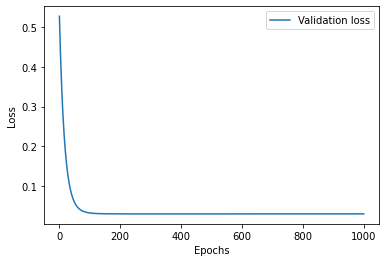

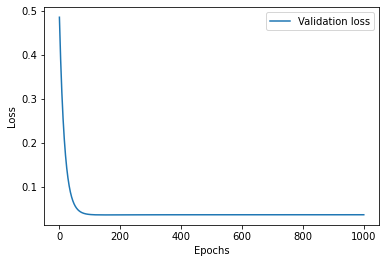

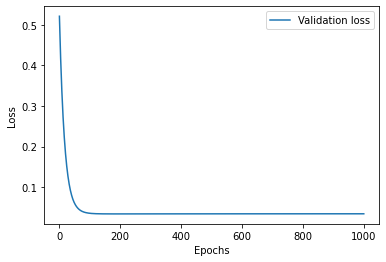

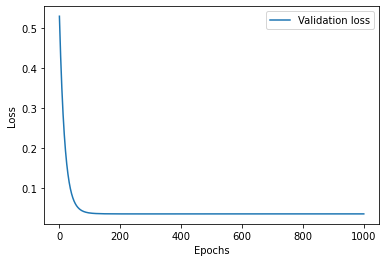

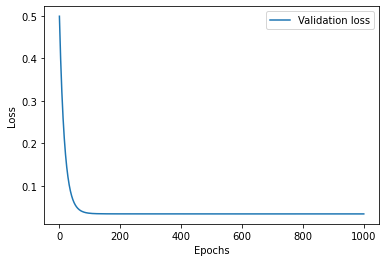

In [153]:
result_1a = Kfold(5,numpy_features,admission["Chance of Admit "].to_numpy(),epochs=1000,learning_rate=0.0001,draw_curve=True)

In [154]:
result_1a.get_weights()

(array([[0.02516913],
        [0.01187608],
        [0.00998109],
        [0.00345194],
        [0.01438838],
        [0.06594068],
        [0.01563077]]),
 array([[0.72260847]]))

Number of epochs with lowest validation: 136
Train error: 0.03744668795439158
Test error: 0.03499071637742731
Number of epochs with lowest validation: 661
Train error: 0.034997426800410736
Test error: 0.037967195882379276
Number of epochs with lowest validation: 166
Train error: 0.03614622054374644
Test error: 0.03197638117845471
Number of epochs with lowest validation: 150
Train error: 0.03614398606777406
Test error: 0.03901107863949124
Number of epochs with lowest validation: 124
Train error: 0.035420501578410105
Test error: 0.03553493525010357
Final results:
Training error:0.036031+-0.000833
Testing error:0.035896+-0.002462


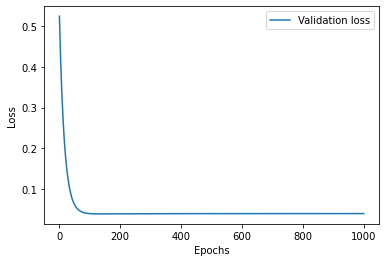

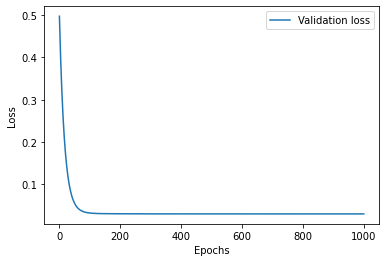

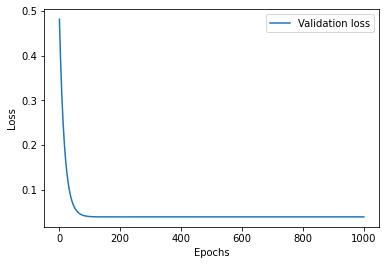

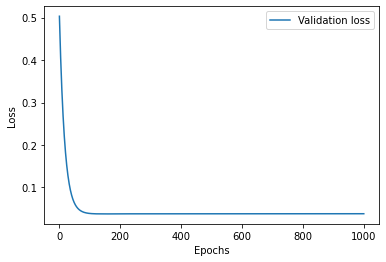

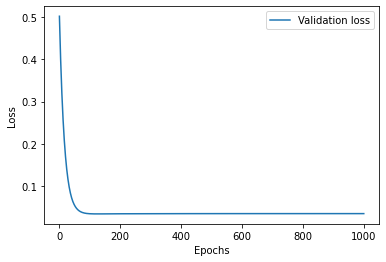

In [151]:
without_GRE = features.drop("GRE Score", axis = 1).values
Kfold(5,without_GRE,admission["Chance of Admit "].to_numpy(),epochs=1000,learning_rate=0.0001,draw_curve=True)

Yes, these are good features because the training error and testing error are within 0.05.     

No, GRE is not that important as the error with or without such feature didnt change much. 

#### 2. Logistic regression using a simple perceptron.     

For whether your status is sufficient to make it off the Titanic, download the Titanic data set from Files.     

 

In [76]:
titanic = pd.read_csv("titanic.csv")
titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(a) Process the dataset. What changes from problem 1? Filter out data with missing features. Use one-hot encoders to transform the categorical features and the output survival status.     
*Hint: Here are some [brief description](http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf) for the dataset if you are unsure what each descriptor means.*     
 

In [93]:
# filter out the missing values
titanic = titanic.dropna()

# extract the features that are related to predicting the survival of the passengers
titanic_feat = titanic[["Pclass", "Sex", "Age", "SibSp", "Parch", "Embarked"]]

# one-hot encode the categorical features
categorical_features = titanic_feat[["Sex", "Embarked"]]
continuous_feats = titanic_feat[["Pclass", "Age", "SibSp", "Parch"]]

# normalize the continuous features
continuous_feats = (continuous_feats - continuous_feats.mean()) / continuous_feats.std()

# Use one-hot encoding to encode the categorical features
encoder = OneHotEncoder()
categorical_features = encoder.fit_transform(categorical_features).toarray()

# horizontally stack the one-hot encoded features and the continuous features
titanic_feat = np.hstack((categorical_features, continuous_feats))

print(titanic_feat.shape)

(183, 9)


Problem 2's dataset contains categorical data as well as continuous data; therefore, how the dataset is manipulated is a bit different. For example, we have to transform categorical data to numbers using one-hot encoding. Whereas in problem 1, we don't have to do so. Furthermore, we also dropped some the data that has missing features to create a more robust model. 

(b) Use the simple perceptron model we developed in Q1. Use 80% of the data from training and 20% of the data for testing and do 5-fold validation. Can we predict who will survive? Play around with the features to determine which ones give you a better chance to get back to shore.   

(183, 1)
Number of epochs with lowest validation: 808
Train error: 0.1609037729631383
Test error: 0.11935297961467728
Number of epochs with lowest validation: 205
Train error: 0.13107358623217694
Test error: 0.27273735409394123
Number of epochs with lowest validation: 1000
Train error: 0.15364034710633395
Test error: 0.13707763694568617
Number of epochs with lowest validation: 1000
Train error: 0.14653550394748846
Test error: 0.17930549809401022
Number of epochs with lowest validation: 1000
Train error: 0.1517764236757312
Test error: 0.14988057915791156
Final results:
Training error:0.148786+-0.009981
Testing error:0.171671+-0.054187


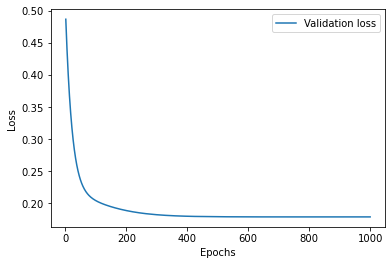

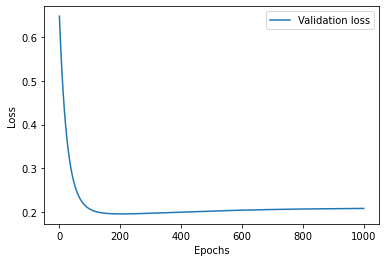

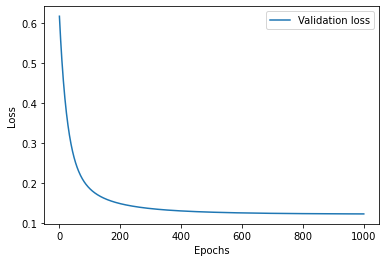

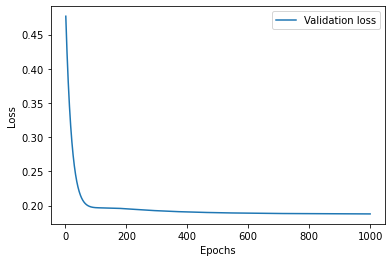

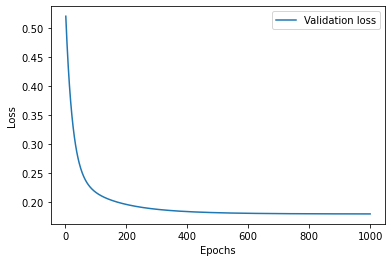

In [161]:
# transform output 
titanic_out = np.array(titanic["Survived"]).reshape((-1,1))
output_encoder = OneHotEncoder()
titanic_out = output_encoder.fit_transform(titanic_out).toarray()
titanic_out = output_encoder.inverse_transform(titanic_out)
print(titanic_out.shape)

# perform Kfold 
result_2b = Kfold(5,titanic_feat,titanic_out,epochs=1000,learning_rate=0.0001,draw_curve=True)

Yes, we can predict who can survive since the error is relatively small. 

In [165]:
result_2b.get_weights()

(array([[ 0.43293183],
        [-0.06631969],
        [ 0.1975931 ],
        [ 0.00518966],
        [ 0.15701789],
        [-0.01520041],
        [-0.04576589],
        [ 0.06566922],
        [-0.04284561]]),
 array([[0.31883951]]))

PClass determines which ones give you a better chance to get back to shore.

#### 3. Nonlinear regression using a simple perceptron and a simple ANN.     
Let's try to fit a simple sine function $y = 3\sin(x)+5$ with the simple perceptron and a simple fully connected network.     



(a) Use the generate_data() function provided in the reference file to generate the trianing data (5000 points). Do 5-fold cross validation with the simple perceptron model. How well is the prediction? Generate 1000 new points as your test data, and use the show_correlation() function to see how well your model agree with the test data.     

 

In [103]:
def generate_X(number):
    xs=(np.random.random(number)*2-1)*10
    return xs
    
def generate_data(number,stochascity=0.05):
    xs=generate_X(number)
    fs=3*np.sin(xs)-5
    stochastic_ratio=(np.random.random(number)*2-1)*stochascity+1
    return xs,fs*stochastic_ratio

Number of epochs with lowest validation: 13
Train error: 4.244032968289447
Test error: 4.27151653445243
Number of epochs with lowest validation: 12
Train error: 4.248756287845526
Test error: 4.236482767159672
Number of epochs with lowest validation: 669
Train error: 4.240721093271619
Test error: 4.305146933335167
Number of epochs with lowest validation: 20
Train error: 4.24397250407689
Test error: 4.272697934255167
Number of epochs with lowest validation: 654
Train error: 4.313842921286667
Test error: 4.201372716981077
Final results:
Training error:4.258265+-0.027907
Testing error:4.257443+-0.035467


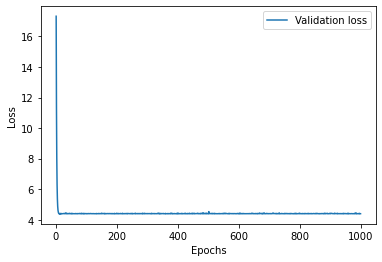

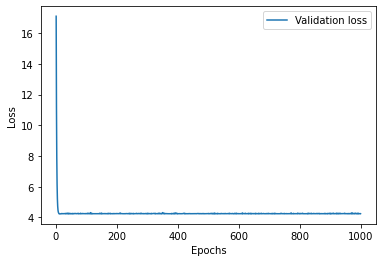

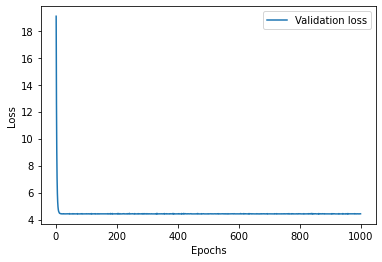

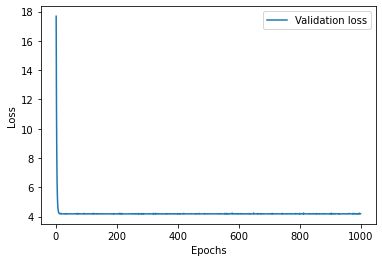

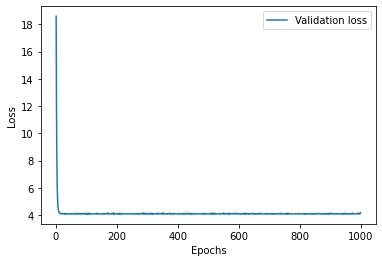

In [160]:
# generate training and testing sets 
train_x, train_y = generate_data(5000,0.1)
test_x, test_y = generate_data(1000,0.1)

train_x = train_x.reshape((-1, 1))
# print(train_x.shape)
train_y = train_y.reshape((-1, 1))
test_x = test_x.reshape((-1, 1))
test_y = test_y.reshape((-1, 1))

# Perform Kfold 
result_3a = Kfold(5,train_x,train_y,epochs=1000,learning_rate=0.0001,draw_curve=True)


Correlation coefficient: 0.21051238090449673


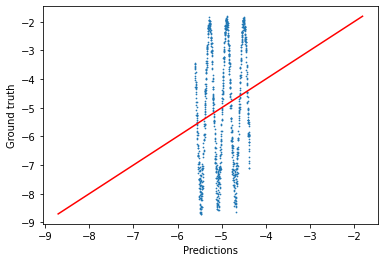

In [115]:
# print(result_3a.predict(test_x).flatten())
# print(test_y.flatten().shape)

show_correlation(result_3a.predict(test_x).flatten(), test_y.flatten())

The prediction is pretty bad as we can see from the coefficient plot above. The pattern isn't even a tiny bit aligned. The overall correlation coefficient is 0.2 which indicates a weak correlation. 

(b) Use the multilayer perceptron regressor of scikit-learn as a simple fully connected neural network. Use one hidden layer with 8 neurons. Do 5-fold cross validation with this simple ANN, and report the MSE on each fold. Visualize the correlation of your model prediction and the true test data. Is the result better than a simple perceptron? 



In [130]:
def KFold_NN(k,Xs,ys,hidden_layers,epochs=1000,lr=0.001):
    # The total number of examples for training the network
    total_num=len(Xs)

    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    train_error_all=[]
    test_error_all=[]
    for train_selector,test_selector in kf.split(range(total_num)):
        # Decide training examples and testing examples for this fold
        train_Xs=Xs[train_selector]
        train_ys=ys[train_selector]
        test_Xs=Xs[test_selector]
        test_ys=ys[test_selector]
        
        # Establish the model here
        model = MLPRegressor(max_iter=epochs, activation='tanh', early_stopping=True, 
                             validation_fraction=0.25, learning_rate='constant', learning_rate_init=lr,
                             hidden_layer_sizes=hidden_layers).fit(train_Xs, train_ys)
        
        ### Report result for this fold ##
        train_error= mean_squared_error(train_ys, model.predict(train_Xs))
        train_error_all.append(train_error)
        test_error= mean_squared_error(test_ys, model.predict(test_Xs))
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)

    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))
    
    # return the last model
    return model

In [140]:
result_3b = KFold_NN(5,train_x,train_y.reshape(-1,),hidden_layers = (8,),epochs=1000,lr=0.001)

Train error: 4.079810480676931
Test error: 3.981521481807089
Train error: 2.308230683703602
Test error: 2.6518689466767755
Train error: 3.534736293029692
Test error: 3.5590874713692884
Train error: 2.388325567534703
Test error: 2.3146586429190568
Train error: 0.5868329058760237
Test error: 0.5583324304520911
Final results:
Training error:2.579587+-1.203683
Testing error:2.613094+-1.189967


/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Correlation coefficient: 0.86205074308908


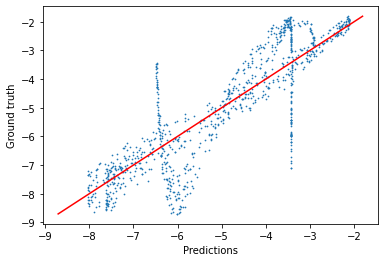

In [133]:
show_correlation(result_3b.predict(test_x).flatten(), test_y.flatten())

Yes, the result is better than a simple perceptron. The overall correlation coefficient is 0.86 which indicates a strong correlation. The pattern is also more aligned. 

(c) Play with the architecture for the ANN, can you improve the performance by including additional hidden layers?

In [147]:
result_3c = KFold_NN(5,train_x,train_y.reshape(-1,),hidden_layers = (10,2),epochs=1000,lr=0.001)

/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error: 0.14057346578782323
Test error: 0.1553558392358634
Train error: 0.13746749642885236
Test error: 0.1275401503172783


/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error: 0.11796605349776475
Test error: 0.13144757444493882
Train error: 0.1482651468030149
Test error: 0.14389212533495732
Train error: 0.14961769163550107
Test error: 0.15791369567053798
Final results:
Training error:0.138778+-0.011363
Testing error:0.143230+-0.012232


/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Correlation coefficient: 0.9816188570173503


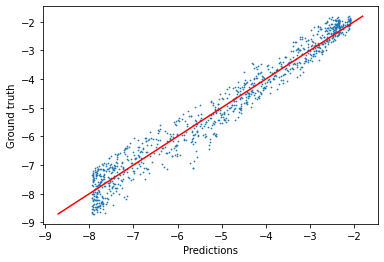

In [148]:
show_correlation(result_3c.predict(test_x).flatten(), test_y.flatten())

I was able to get the correlation coefficent even higher to almost 1 with hidden layer 10 by 10. 

### Charis Playing Around 

I got some interesting graphs :") and I don't want to delete them. 

/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error:  4.284413422552241


/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error:  1.6981512604086366


/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error:  4.010016673439606


/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error:  2.833252459058724
Mean squared error:  3.754643290696827


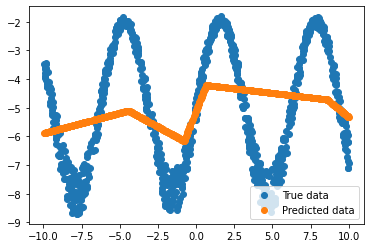

In [134]:
# create a multilayer perceptron regressor
mlp = MLPRegressor(hidden_layer_sizes=(8,), activation='relu', solver='adam', max_iter=1000)

# Do 5-fold cross validation
kf = KFold(n_splits=5)

for train_index, test_index in kf.split(train_x):
    X_train, X_test = train_x[train_index], train_x[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]
    mlp.fit(X_train.reshape(-1,1), y_train)
    pred_y = mlp.predict(X_test.reshape(-1,1))
    mse = mean_squared_error(y_test, pred_y)
    print("Mean squared error: ", mse)
    
# visualize correlation of your model prediction and the true test data. 
pred_y = mlp.predict(test_x.reshape(-1,1))
plt.scatter(test_x, test_y, label="True data")
plt.scatter(test_x, pred_y, label="Predicted data")
plt.legend()
plt.show()

/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error:  0.1324523585316396


/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error:  0.7823970278171434


/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error:  0.9457961975753981


/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error:  0.12046657883945419


/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error:  0.8894616386339662


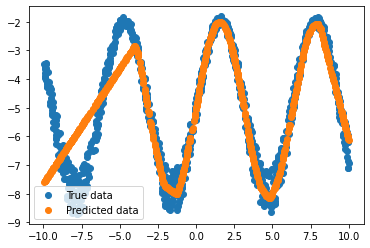

In [135]:
mlp = MLPRegressor(hidden_layer_sizes=(100,100), activation='relu', solver='adam', max_iter=1000)

# Do 5-fold cross validation
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(train_x):
    X_train, X_test = train_x[train_index], train_x[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]
    mlp.fit(X_train.reshape(-1,1), y_train)
    pred_y = mlp.predict(X_test.reshape(-1,1))
    mse = mean_squared_error(y_test, pred_y)
    print("Mean squared error: ", mse)
    
# visualize correlation of your model prediction and the true test data. 
pred_y = mlp.predict(test_x.reshape(-1,1))
plt.scatter(test_x, test_y, label="True data")
plt.scatter(test_x, pred_y, label="Predicted data")
plt.legend()
plt.show()